#  Predição de Preços de Carros usando Modelos Ensemble: Cat Boost

###  Este modelo implementa um modelo Cat Boost para prever preços de carros.

### 1. Importação das Bibliotecas


In [65]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
import joblib
import category_encoders as ce
from catboost import CatBoostRegressor


### 2. Funções Auxiliares

In [66]:
def knn_input(df, n_neighbors=5):   
    df_encoded = df.copy()
    for col in df_encoded.select_dtypes(include='object').columns:
        df_encoded[col] = df_encoded[col].astype('category').cat.codes
    knn_imputer = KNNImputer(n_neighbors=n_neighbors)
    df_imputed = pd.DataFrame(knn_imputer.fit_transform(df_encoded), columns=df_encoded.columns)
    for col in df.select_dtypes(include='object').columns:
        df_imputed[col] = df_imputed[col].round().astype(int).map(
            dict(enumerate(df[col].astype('category').cat.categories)))
    return df_imputed

def remove_outliers_iqr(df, column):   
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1   
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR    
    df_out = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df_out

### 3. Carregamento e Pré-processamento dos Dados

In [67]:
train_path = '../data/raw/train.csv'
df = pd.read_csv(train_path)


In [68]:
df_input = knn_input(df, n_neighbors=25)

# Calcular a idade do carro
df_input['car_age'] = 2024 - df_input['model_year']
df_input = df_input.drop(columns=['model_year'], errors='ignore')

# Criar features compostas
df_input['engine_transmission'] = df_input['engine'].astype(str) + "_" + df_input['transmission'].astype(str)
df_input['int_ext_color'] = df_input['int_col'].astype(str) + "_" + df_input['ext_col'].astype(str)

# Remover colunas originais usadas nas features compostas
df_input.drop(columns=['engine', 'transmission', 'int_col', 'ext_col'], inplace=True, errors='ignore')

# Remover a coluna 'clean_title' se existir
if 'clean_title' in df_input.columns:
    df_input.drop(columns=['clean_title'], inplace=True)

In [69]:
# Identificar colunas categóricas
cat_cols_train = df_input.select_dtypes(include=['object']).columns.tolist()

# Inicializar o TargetEncoder
target_encoder = ce.TargetEncoder(cols=cat_cols_train)

# Separar features e target
X = df_input.drop(columns=['price', 'id'], errors='ignore')  # Remover 'price' e 'id' se existirem
y = df_input['price']

# Aplicar o TargetEncoder
X[cat_cols_train] = target_encoder.fit_transform(X[cat_cols_train], y)

# Salvar o encoder
encoder_path = '../models/target_encoder.pkl'
joblib.dump(target_encoder, encoder_path)

['../models/binary_encoder.pkl']

In [70]:
X[cat_cols_train]

,brand,model,fuel_type,engine_transmission,int_ext_color
0,17162.015977,12832.716263,43360.013782,9835.852843,24298.380859
1,30712.595130,21685.985622,43360.013782,11618.909749,25927.069915
2,41836.755127,24076.610913,26729.755457,16928.023316,29285.683339
3,53556.327141,48913.057303,43360.013782,45032.467144,43593.367553
4,51244.399541,64896.257198,43360.013782,46881.573330,29846.327045
...,...,...,...,...,...
188528,45659.094780,51053.165468,43360.013782,52458.697080,31368.252820
188529,51244.399541,56181.136254,43360.013782,57514.589725,44476.252506
188530,51244.399541,63980.296474,43360.013782,62372.073818,44476.252506
188531,41004.856985,37505.533835,43360.013782,50389.941237,67000.403986


In [71]:
# Remover outliers
df_train_no_outliers = remove_outliers_iqr(X.assign(price=y), 'milage')
df_train_no_outliers = remove_outliers_iqr(df_train_no_outliers, 'price')
df_train_no_outliers.reset_index(drop=True, inplace=True)

# Atualizar X e y após remoção de outliers
X = df_train_no_outliers.drop(columns=['price'], errors='ignore')
y = df_train_no_outliers['price']  # Correção: usar df_train_no_outliers['price']

### 4. Preparação para Modelagem

In [72]:
seed = 42

# Certifique-se de que X e y já estão definidos a partir de df_train_no_outliers
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)


In [73]:
X_train

,brand,model,milage,fuel_type,accident_0,accident_1,car_age,engine_transmission,int_ext_color
57584,40511.969508,42709.795925,49170.0,26729.755457,0,1,6.0,26541.967517,25667.053844
121371,41004.856985,37505.533835,89500.0,43360.013782,0,1,9.0,26205.870712,43593.367553
54717,21521.107938,26295.242816,110000.0,43360.013782,0,1,9.0,42311.366031,48368.532973
97920,34801.090131,12885.316614,165000.0,43360.013782,0,1,17.0,10802.345498,26595.807018
69085,33371.679487,36255.577221,87500.0,43360.013782,0,1,5.0,34297.164983,49314.079514
...,...,...,...,...,...,...,...,...,...
119879,33371.679487,27301.297524,51890.0,43360.013782,0,1,11.0,22368.578461,43593.367553
103694,51244.399541,45137.170868,120000.0,43360.013782,1,0,7.0,41392.830831,44476.252506
131932,43659.775487,58951.160296,35000.0,43360.013782,0,1,6.0,59492.799368,59328.263548
146867,38936.163919,40974.505543,157272.0,43360.013782,0,1,6.0,36244.930131,29285.683339


In [74]:
# Inicializar o StandardScaler
scaler = StandardScaler()

# Identificar colunas numéricas para escalonamento
numeric_cols = ['brand', 'model', 'car_age', 'milage', 'fuel_type',
               'engine_transmission', 'int_ext_color']

# Verificar se todas as colunas existem no DataFrame
missing_cols = [col for col in numeric_cols if col not in X_train.columns]
if missing_cols:
    print(f"Atenção: As seguintes colunas estão faltando no X_train e não serão escalonadas: {missing_cols}")

# Aplicar o scaler apenas nas colunas numéricas existentes
existing_numeric_cols = [col for col in numeric_cols if col in X_train.columns]

# Escalonar os dados de treino
X_train[existing_numeric_cols] = scaler.fit_transform(X_train[existing_numeric_cols])

# Escalonar os dados de teste
X_test[existing_numeric_cols] = scaler.transform(X_test[existing_numeric_cols])

# Salvar o scaler se necessário
scaler_path = '../models/standard_scaler.pkl'
joblib.dump(scaler, scaler_path)

['../models/standard_scaler.pkl']

### 5. Treinamento e Avaliação do Modelo

In [75]:
# Inicializar o modelo CatBoost
catboost_model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.1,
    depth=10,
    random_state=42,
    early_stopping_rounds=50,
    verbose=100
)

# Treinar o modelo
catboost_model.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True)

# Fazer previsões
catboost_pred = catboost_model.predict(X_test)

# Avaliar o modelo
catboost_rmse = np.sqrt(mean_squared_error(y_test, catboost_pred))
catboost_r2 = r2_score(y_test, catboost_pred)
print(f"CatBoost RMSE: {catboost_rmse:.2f}")
print(f"CatBoost R²: {catboost_r2:.2f}")

0:	learn: 20183.7369790	test: 20152.9342363	best: 20152.9342363 (0)	total: 32.9ms	remaining: 32.8s
100:	learn: 12949.6465706	test: 13137.8161357	best: 13137.8161357 (100)	total: 3.34s	remaining: 29.7s
200:	learn: 12631.6417633	test: 13049.0542604	best: 13049.0542604 (200)	total: 6.27s	remaining: 24.9s
300:	learn: 12383.7302605	test: 13017.5676680	best: 13017.5676680 (300)	total: 9.22s	remaining: 21.4s
400:	learn: 12172.9715982	test: 13006.3572676	best: 13005.0131754 (388)	total: 12.2s	remaining: 18.3s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 13000.10777
bestIteration = 444

Shrink model to first 445 iterations.
CatBoost RMSE: 13000.11
CatBoost R²: 0.63


In [76]:
X_train

,brand,model,milage,fuel_type,accident_0,accident_1,car_age,engine_transmission,int_ext_color
57584,-0.159911,0.032214,-0.378978,-3.639324,0,1,-0.415243,-0.692515,-1.342862
121371,-0.126714,-0.196829,0.482379,-0.104728,0,1,0.121007,-0.707744,0.109830
54717,-1.438987,-0.690201,0.920213,-0.104728,0,1,0.121007,0.022038,0.496794
97920,-0.544551,-1.280381,2.094888,-0.104728,0,1,1.551005,-1.405719,-1.267599
69085,-0.640825,-0.251840,0.439664,-0.104728,0,1,-0.593992,-0.341106,0.573418
...,...,...,...,...,...,...,...,...,...
119879,-0.640825,-0.645924,-0.320885,-0.104728,0,1,0.478506,-0.881622,0.109830
103694,0.562941,0.139045,1.133790,-0.104728,1,0,-0.236493,-0.019583,0.181376
131932,0.052101,0.747007,-0.681617,-0.104728,0,1,-0.415243,0.800574,1.384936
146867,-0.266045,-0.044157,1.929835,-0.104728,0,1,-0.415243,-0.252848,-1.049620


### 6. Análise de Feature Importance

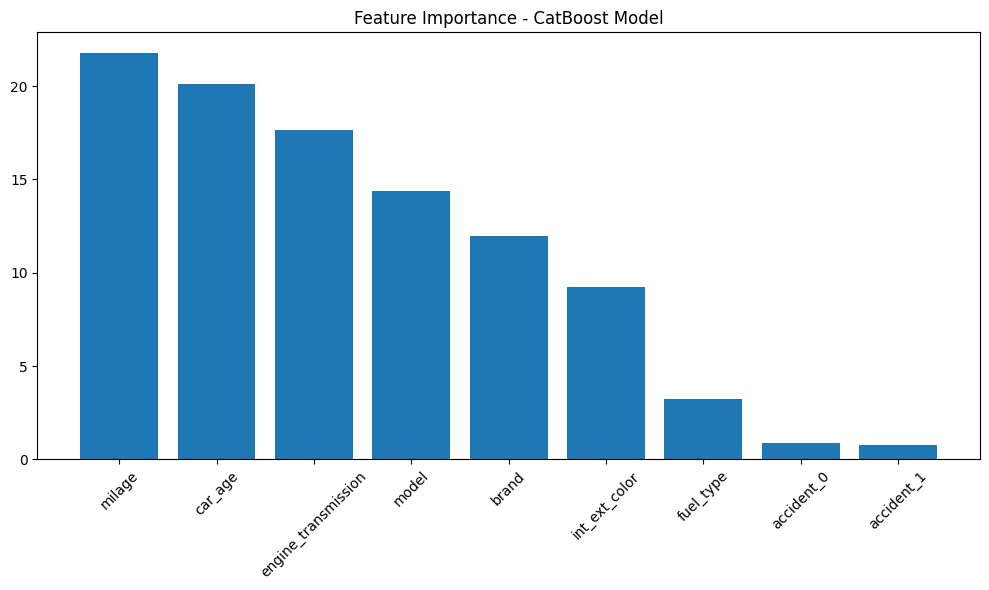

In [77]:
def plot_feature_importance(model, title):
    importance_df = pd.DataFrame({
        'feature': X.columns,
        'importance': model.feature_importances_
    })
    importance_df = importance_df.sort_values('importance', ascending=False)
    plt.figure(figsize=(10, 6))
    plt.bar(importance_df['feature'], importance_df['importance'])
    plt.xticks(rotation=45)
    plt.title(f'Feature Importance - {title}')
    plt.tight_layout()
    plt.show()

plot_feature_importance(catboost_model, 'CatBoost Model')

In [78]:
model_name = 'catboost'
model_path = f'../models/car_price_{model_name}.pkl'
joblib.dump(catboost_model, model_path)

['../models/car_price_catboost.pkl']